# Fase de Modelización 

## Carga del modelo MovilNet

En este primer punto vamos a cargar el modelo MovilNet para iniciar la fase de entrenamiento del modelo con los datos obtenidos en la fase de preanalisis y resolución. Luego probaremos una segunda parte con una CNN creada desde cero para contrastar resultados

### 1. Importamos las librerias que necesitamos para instanciar el modelo 

In [3]:
from IPython.display import display, Javascript

display(Javascript('IPython.notebook.kernel.restart()'))

<IPython.core.display.Javascript object>

In [1]:
%run imports.py
from funciones import *

In [2]:
df_model = pd.read_csv("output\model_photosv1.0.csv")
df_model.shape

(7965, 4)

In [6]:
df_model = df_model[["photo_id", "label"]]
df_model["path_files"] = create_path(df_model)
df_model.head()

Creando rutas: 100%|██████████| 7965/7965 [00:34<00:00, 232.91it/s]
C:\Users\varel\AppData\Local\Temp\ipykernel_19536\1239584283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["path_files"] = create_path(df_model)


,photo_id,label,path_files
0,6LJa8QZOGBjt9maE5miLhw,menu,photos\6LJa8QZOGBjt9maE5miLhw.jpg
1,T_QaBsquJlzAQd5bbCrLfA,outside,photos\T_QaBsquJlzAQd5bbCrLfA.jpg
2,DtsfhqhqUB-tjs5XbwJfXw,menu,photos\DtsfhqhqUB-tjs5XbwJfXw.jpg
3,Iehiw_bcHnXw-pg0w2M06w,drink,photos\Iehiw_bcHnXw-pg0w2M06w.jpg
4,JClkivVTbSvCJAsdqtOa2g,inside,photos\JClkivVTbSvCJAsdqtOa2g.jpg


In [8]:
df_model = df_model.reindex(columns=["photo_id", "path_files", "label"])
df_model.head()

,photo_id,path_files,label
0,6LJa8QZOGBjt9maE5miLhw,photos\6LJa8QZOGBjt9maE5miLhw.jpg,menu
1,T_QaBsquJlzAQd5bbCrLfA,photos\T_QaBsquJlzAQd5bbCrLfA.jpg,outside
2,DtsfhqhqUB-tjs5XbwJfXw,photos\DtsfhqhqUB-tjs5XbwJfXw.jpg,menu
3,Iehiw_bcHnXw-pg0w2M06w,photos\Iehiw_bcHnXw-pg0w2M06w.jpg,drink
4,JClkivVTbSvCJAsdqtOa2g,photos\JClkivVTbSvCJAsdqtOa2g.jpg,inside


In [10]:
# Cargado de Imagenes y Formateo a (n, 244, 244, 3)
images, labels = image_label_load(df_model)

# Codificar las etiquetas
label_encoder = LabelEncoder()  # Instancia del encoder 
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded, num_classes=5)  # Especificar 5 clases
 
print(f"Shape of images: {images.shape}")
print(f"Shape of labels encoded: {labels_encoded.shape}")


Codificando imagenes: 7965it [01:08, 115.85it/s]


Shape of images: (7965, 244, 244, 3)
Shape of labels encoded: (7965, 5)


In [13]:
# Carga del MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244,244,3))

# Congelar capas base del modelo -> Conserva los pesos establecidos por el aprendizaje de imagenet
base_model.trainable = False 

#Añadimos capas superiores para ajustar el modelo a nuestro caso concreto: 
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation='relu')(x) 

predictions = Dense(5, activation='softmax')(x) # Ajuste para 5 clases (menu, outside, drink, inside, food)

# Instancia del MobileNetV2 + capas superiores 
model = Model(inputs=base_model.input, outputs=predictions)

# Compilacion del modelo en conjunto: 
model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.save("Modelo_Base.keras")

C:\Users\varel\AppData\Local\Temp\ipykernel_19536\264039011.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244,244,3))


In [14]:
# Train/Test split -> Division  de conjuntos de datos en entrenamiento y validacion 
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.25, random_state=41)
# Data Augmentation --> para ganar mas variedad de datos a la hora de entrenar 
"""
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
"""
                ### HIPER-PARAMETROS DE DATA AUGMENTATION PARA ENTRENAMIENTO ###
datagen = ImageDataGenerator()
# Ajustamos el generador de datos al conjunto de entrenamiento 
datagen.fit(X_train)

In [15]:
# Numero de pasos por epoch
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
# Entrenar el modelo
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10


c:\Users\varel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.5779 - loss: 1.0748 - val_accuracy: 0.7234 - val_loss: 0.7315
Epoch 2/10
  1/186 ━━━━━━━━━━━━━━━━━━━━ 4:28 1s/step - accuracy: 0.5938 - loss: 0.8486

c:\Users\varel\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


186/186 ━━━━━━━━━━━━━━━━━━━━ 94s 502ms/step - accuracy: 0.5938 - loss: 0.8486 - val_accuracy: 0.7209 - val_loss: 0.7458
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7495 - loss: 0.6843 - val_accuracy: 0.7435 - val_loss: 0.6916
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 86s 458ms/step - accuracy: 0.5938 - loss: 0.7609 - val_accuracy: 0.7450 - val_loss: 0.6923
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.7758 - loss: 0.6171 - val_accuracy: 0.7540 - val_loss: 0.6626
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 94s 502ms/step - accuracy: 0.7812 - loss: 0.5565 - val_accuracy: 0.7480 - val_loss: 0.6649
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.8057 - loss: 0.5578 - val_accuracy: 0.7600 - val_loss: 0.6396
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 103s 547ms/step - accuracy: 0.6875 - loss: 0.7795 - val_accuracy: 0.7615 - val_loss: 0.6423
Epoch 9/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8184 - loss: 0.5013 - val_accura

In [19]:
labels_encoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [16]:
model.save("Modelo_Base_entrenado.keras")

63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step
F1-score: 0.7502730197361188
Accuracy: 0.7484939759036144
              precision    recall  f1-score   support

       drink       0.80      0.75      0.78       422
        food       0.83      0.79      0.81       387
      inside       0.71      0.60      0.65       411
        menu       0.92      0.73      0.81       369
     outside       0.60      0.88      0.71       403

    accuracy                           0.75      1992
   macro avg       0.77      0.75      0.75      1992
weighted avg       0.77      0.75      0.75      1992



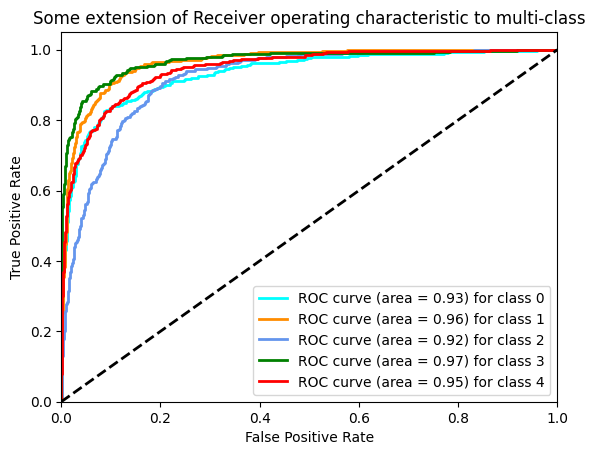

In [17]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


# Calcular el F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f'F1-score: {f1}')

# Calcular el accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Generar el reporte de clasificación
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print(report)

# Generar la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear todas las curvas ROC
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0]) # apuntar 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()